## Семинар 5: "Глубинное обучение, часть 1"

ФИО:

In [206]:
from builtins import range
from __future__ import division
from __future__ import print_function
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from sklearn.metrics import classification_report
from timeit import default_timer as timer
import gc
%matplotlib inline


import sys

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

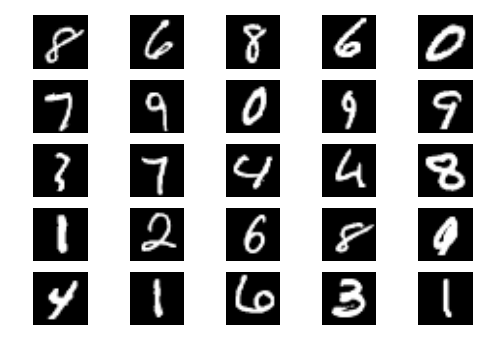

In [184]:
# обратите внимание, что данные имеют размерость examples x channels x w x h
mnist = fetch_mldata('MNIST original')
images = mnist['data']
images = images.reshape(images.shape[0], 1, 28, 28)
labels = mnist['target'].astype(int)
np.random.seed(777)
images_train, images_test, labels_train, labels_test = train_test_split(images, labels)
for i in xrange(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images_train[i, 0, :, :], cmap=plt.cm.Greys_r)
    plt.axis('off')

images_train = images_train.reshape(images_train.shape[0], 28 * 28)
images_train = torch.from_numpy(images_train).type(torch.FloatTensor)
images_test= images_test.reshape(images_test.shape[0], 28 * 28)
images_test = torch.from_numpy(images_test).type(torch.FloatTensor)
labels_train = torch.from_numpy(labels_train)
labels_test = torch.from_numpy(labels_test)

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 -> 500 -> 300 -> 50 -> 10. В качестве активации возьмите сигмоиду

In [185]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=1)

def forward_hook(self, input_, output, reciever = None):
    std = input_[0].std().data[0]
    if not reciever is None:
        reciever.append(std)
    else:
        print ('forward', std)

def backward_hook(self, grad_input, grad_output, reciever = None):
    std = grad_input[1].std().data[0]
    if not reciever is None:
        reciever.append(std)
    else:
        print ('backward', std)

    
def init_arch(shapes, init_func, forward_hook, backward_hook, activation,
                                 for_rec = None, back_rec = None):
    arr = []
    for i in range(len(shapes) - 1):
        layer = nn.Linear(shapes[i], shapes[i+1])
        init_func(layer)
        layer.register_forward_hook(lambda x, y, z : forward_hook(x, y, z, for_rec))
        layer.register_backward_hook(lambda x, y, z : backward_hook(x, y, z, back_rec))
        arr.append(layer)
        arr.append(activation())
    model = nn.Sequential(*arr[:-1])
    return model
    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

print (layer.state_dict()['weight'].size())

torch.Size([10, 784])


<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [186]:
# normal noise

def test_model(init_layer, forward_hook, backward_hook, activation, shapes = (784, 500, 500, 300, 50, 10), 
               images_train = images_train):
    back_rec = list()
    for_rec = list()
    model = init_arch(shapes, init_layer, forward_hook, backward_hook, activation, for_rec, back_rec)
    n_objects = 100
    X = Variable(images_train[:n_objects], requires_grad=False).view(n_objects, -1)
    y = Variable(labels_train[:n_objects], requires_grad=False)
    activations = model(X)
    loss_fn = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 
    loss = loss_fn(activations, y)
    loss.backward()
    return for_rec, back_rec
 


#пример:

noise_forw_rec, noise_back_rec = test_model(init_layer, forward_hook, backward_hook, activation = nn.Sigmoid)
print (noise_forw_rec)
print (noise_back_rec)


[77.61759948730469, 0.4998074173927307, 0.47496670484542847, 0.473200261592865, 0.4646115005016327]
[0.04148935154080391, 0.008846591226756573, 0.002799505367875099, 0.0026845464017242193, 0.03412625566124916]


<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [187]:
def init_xavier(layer):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    ni_inc, ni = weight.size()
    r = np.sqrt(6) /  np.sqrt(ni + ni_inc)
    weight.uniform_(-r, r)
    

def init_he_i(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    ni_inc, ni = weight.size()
    weight.normal_(0, 2 / ni)
    
def init_he_iplus(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    ni_inc, ni = weight.size()
    weight.normal_(0, 2 / ni_inc)    

In [188]:
#Xavier
xav_forw_rec, xav_back_rec = test_model(init_xavier, forward_hook, backward_hook, activation=nn.Sigmoid)
print ("Xavier", xav_forw_rec, xav_back_rec, sep="\n")
#He_i
he_i_forw_rec, he_i_back_rec = test_model(init_he_i, forward_hook, backward_hook, activation=nn.Sigmoid)
print ("He_i", he_i_forw_rec, he_i_back_rec, sep="\n")
#He_iplus
he_iplus_forw_rec, he_iplus_back_rec = test_model(init_he_iplus, forward_hook, backward_hook, activation=nn.Sigmoid)
print ("He_iplus", he_iplus_forw_rec, he_iplus_back_rec, sep="\n")

Xavier
[77.61759948730469, 0.4947417676448822, 0.1543743908405304, 0.13426841795444489, 0.12304973602294922]
[0.017331544309854507, 0.006911451928317547, 0.0008911495679058135, 0.0001925642427522689, 0.0002646205248311162]
He_i
[77.61759948730469, 0.4275340735912323, 0.014423117972910404, 0.010517298243939877, 0.012206297367811203]
[0.011683637276291847, 0.0017399260541424155, 1.9704784790519625e-05, 4.051159407936211e-07, 3.055612580737943e-07]
He_iplus
[77.61759948730469, 0.4550601840019226, 0.015711670741438866, 0.01873738132417202, 0.08133703470230103]
[0.014364026486873627, 0.007779273670166731, 0.0005195136182010174, 1.6857155060279183e-05, 9.125544238486327e-06]


<i> 1.4 Сделайте выводы по первой части </i>

Построим графики дисперсий для активаций и градиентов для всех активаций

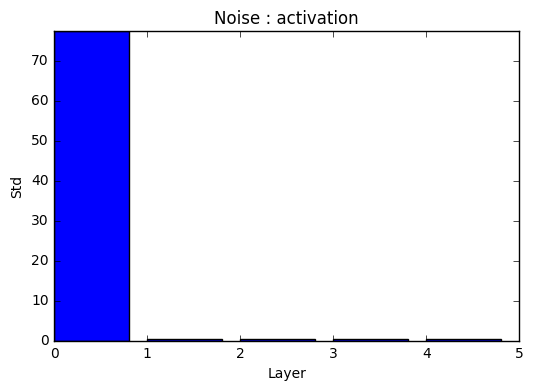

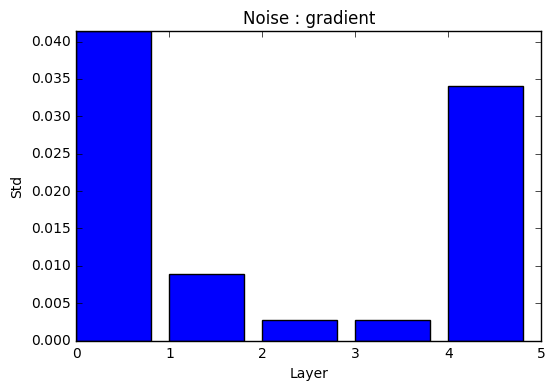

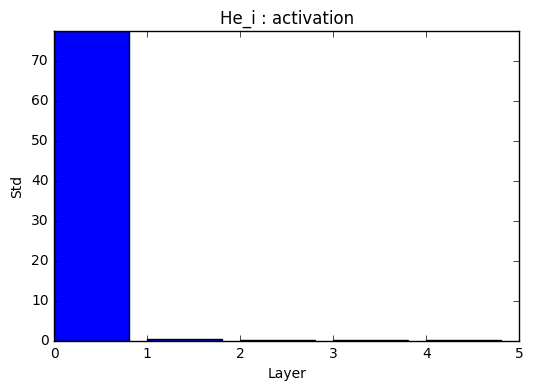

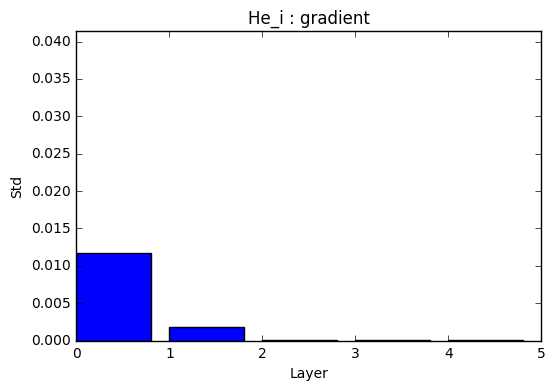

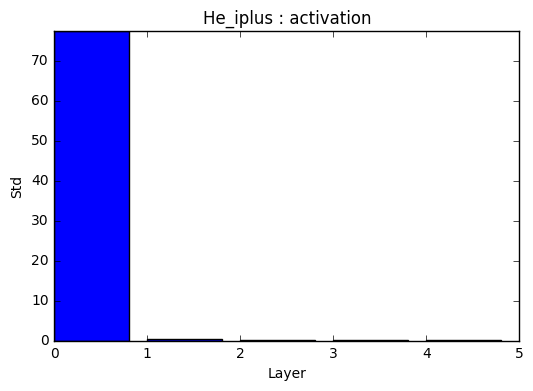

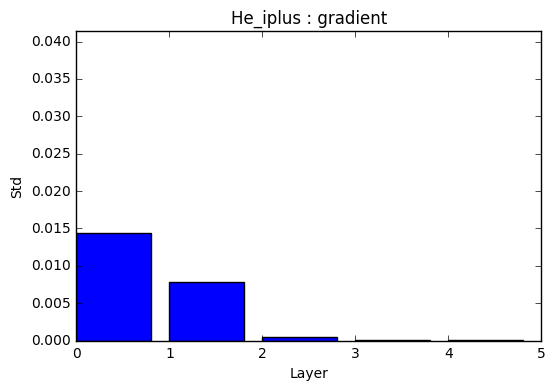

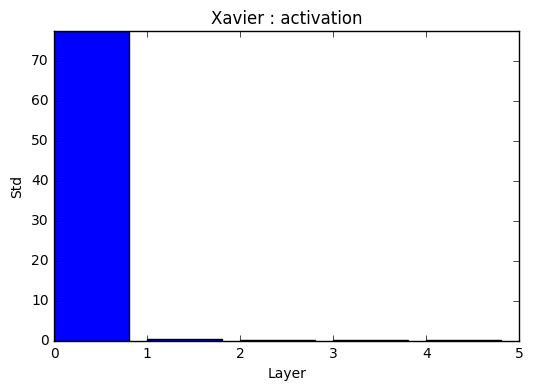

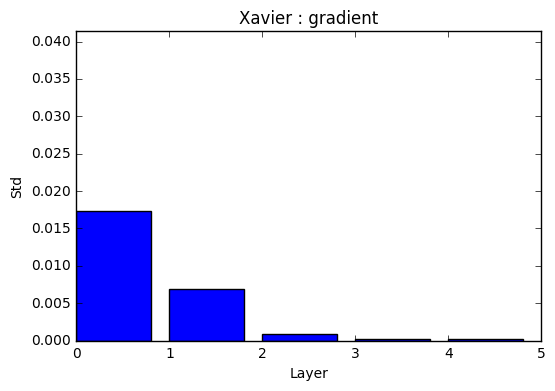

In [189]:
def draw_plot(title, rec, lim):
    plt.ylim(0,lim)
    plt.title(title)
    plt.xlabel("Layer")
    plt.ylabel("Std")
    plt.bar(np.arange(len(rec)), rec)
    plt.show()

forw_lim = np.max( [np.max(noise_forw_rec), np.max(he_i_forw_rec),
                 np.max(he_iplus_forw_rec), np.max(xav_forw_rec)])

back_lim = np.max( [np.max(noise_back_rec), np.max(he_i_back_rec),
                 np.max(he_iplus_back_rec), np.max(xav_back_rec)])

draw_plot("Noise : activation", noise_forw_rec, forw_lim)
draw_plot("Noise : gradient", noise_back_rec, back_lim)

draw_plot("He_i : activation", he_i_forw_rec, forw_lim)
draw_plot("He_i : gradient", he_i_back_rec, back_lim)

draw_plot("He_iplus : activation", he_iplus_forw_rec, forw_lim)
draw_plot("He_iplus : gradient", he_iplus_back_rec, back_lim)

draw_plot("Xavier : activation", xav_forw_rec, forw_lim)
draw_plot("Xavier : gradient", xav_back_rec, back_lim)



Видим, что в случае инициализаций He и Xavier получаем для обратного распространения быстро и равномерно убывающий градиент, чего не видим в случае нормального шума

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [267]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры
# не забывайте, что в pyTorch нету broadcasting (делайте .repeat)



class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p = 0.4):
        super(DropConnect, self).__init__()
        weight = nn.Parameter(torch.Tensor(input_dim, output_dim).normal_(mean=0, std=0.01), requires_grad=True)
        bias = nn.Parameter(torch.Tensor(1, output_dim).zero_(), requires_grad=True)
        self.register_parameter('weight', weight)
        self.register_parameter('bias', bias)
        self.p = torch.Tensor(np.array([[p]], dtype=float)).expand(input_dim, output_dim)
        self.is_train = True

    def forward(self, x):
        if self.is_train:
            m = Variable(torch.bernoulli(self.p), requires_grad=False)
            forw_w = Variable(torch.zeros(*self.weight.size()), requires_grad=True)
            forw_w = forw_w.addcmul(m, self.weight)
            return torch.mm(x, forw_w) + self.bias.expand(x.size()[0], self.bias.size()[1])
        else:
            return torch.mm(x, self.weight * p[0,0]) + self.bias.expand(x.size(0), self.bias.size(1))
    def train(self):
        self.is_train = True
    def test(self):
        self.is_train = False

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с сигмоидами и Dropout между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с сигмоидами DropConnect вместо всех линейных слоев
</i>

In [242]:
#was copied from previous homework
def print_work_time(func):
    def wrapper(*args, **kwargs):
        start = timer()
        result = func(*args, **kwargs)
        end = timer()
        print("Execution take {}".format(end - start))
        return result
    return wrapper

@print_work_time
def learn_on_model(X, Y, model, loss_fn, X_test = None, Y_test = None, learning_rate = 1e-2, 
                   batch_size = 100, max_epoch_num = 1, min_loss = 1e-3): 



    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)    
    loss = 1000
    epoch_num = 0
     
    loss_arr = list()

    test_loss_arr = list() if not (type(X_test) is None) else None
    tot_err = 10**6
    X = X.numpy().copy()
    Y = Y.numpy().copy()

    while tot_err > min_loss and epoch_num < max_epoch_num:
        model = model.eval()
        perm = np.random.permutation(X.shape[0])
        X = X[perm]
        Y = Y[perm]
        tot_err = 0
        sys.stdout.write("Epoch {} ...\n".format(epoch_num + 1))
        for bn, start in enumerate(xrange(0, X.shape[0], batch_size)):
            optimizer.zero_grad()
            if bn % 100 == 0:
                sys.stdout.write("Train Batch {}\n".format(bn))
            X_CUR = Variable(torch.from_numpy(X[start:start + batch_size]))
            Y_CUR = Variable(torch.from_numpy(Y[start:start + batch_size]), requires_grad=False)
            output =  model.forward(X_CUR)
            loss = loss_fn(output, Y_CUR)
            loss_arr.append(loss.data.tolist()[0])
            tot_err += loss
            loss.backward()
            optimizer.step()
            del loss
            del X_CUR
            del Y_CUR
            del output

        
        if not (type(X_test) is None):
            model = model.train()
            for bn, start in enumerate(xrange(0, X_test.size()[0], batch_size)):
                if bn % 100 == 0:
                    sys.stdout.write("Test Batch {}\n".format(bn))
                X_CUR = Variable(X_test[start:start + batch_size])
                Y_CUR = Variable(Y_test[start:start + batch_size])
                y_pred = model.forward(X_CUR)
                loss = loss_fn(y_pred, Y_CUR)
                test_loss_arr.append(loss.data.tolist()[0])
                del X_CUR
                del Y_CUR
                del y_pred
                del loss
            
            
        epoch_num += 1
        gc.collect() # only this've helped to save process from beeing kill
    model = model.train()
    return np.array(loss_arr), np.array(test_loss_arr)

def draw_plots(model, loss_arr, layer_arr, test_loss_arr, show_weights = False):
    x = np.arange(loss_arr.shape[0]);
    number_of_plots = 1 + sum(len(x) for x in layer_arr)
    gridSize = number_of_plots
    plt.figure(figsize=(15, 6 * number_of_plots))
    
    plotId = 1
    subpl = plt.subplot(gridSize, 1, plotId)
    if not type(test_loss_arr) is None:
        subpl.plot(x, loss_arr, x, test_loss_arr)
        subpl.legend(["Train", "Test"])
    else:
        subpl.plot(x, loss_arr)
    subpl.set_xticks(range(x.shape[0]))
    subpl.set_title("Loss function")
    subpl.set_xlabel("Epoch num")
    subpl.set_ylabel("Loss func")
    if show_weights:
        for ind1, child in enumerate(model.children()):
            for ind2, key in enumerate(child.state_dict().keys()):
                plotId += 1
                subpl = plt.subplot(gridSize, 1, plotId)
                y = layer_arr[ind1][ind2]
                subpl.plot(x, y)

                subpl.set_xticks(range(x.shape[0]))
                subpl.set_title("Layer {} : {} gradient norm".format(ind1 + 1, key))
                subpl.set_xlabel("Epoch num")
                subpl.set_ylabel(key + "_grad")
    
    plt.show()

from sklearn.metrics import classification_report

def make_classification_report(model, X_TRAIN, Y_TRAIN, X_TEST, Y_TEST, batch_size = 100):
    model = model.eval()
    print ("Train report")
    y_predicted = np.zeros(shape = (Y_TRAIN.size()[0], 10))
    
    for bn, start in enumerate(xrange(0, X_TRAIN.size()[0], batch_size)):
        if bn % 100 == 0:
            sys.stdout.write("Batch {}\n".format(bn))
        X_CUR = Variable(X_TRAIN[start:start + batch_size])
        
        
        y_predicted[start:start + batch_size] = np.array(model.forward(X_CUR).data.tolist())
    indices = np.argmax(y_predicted, axis = 1)
    print (classification_report(np.array(Y_TRAIN.tolist()), indices))
    print ("Accuracy", np.mean(np.array(Y_TRAIN.tolist()) == indices))
    
    print ("Test report")
    y_predicted = np.zeros(shape = (Y_TEST.size()[0], 10))
    for bn, start in enumerate(xrange(0, X_TEST.size()[0], batch_size)):
        if bn % 100 == 0:
            sys.stdout.write("Batch {}\n".format(bn))
        X_CUR = Variable(X_TEST[start:start + batch_size])
        y_predicted[start:start + batch_size] = np.array(model.forward(X_CUR).data.tolist())
        del X_CUR
        
    
    
    indices = np.argmax(y_predicted, axis = 1)
    print (classification_report(np.array(Y_TEST.tolist()), indices))
    print ("Accuracy", np.mean(np.array(Y_TEST.tolist()) == indices))

    


In [246]:
#784 -> 200 -> 200 -> 10 с сигмоидами и Dropout между всеми слоями
def DropoutNet():
    lst = []
    lst.append(nn.Linear(784, 200))
    lst.append(nn.Sigmoid())
    lst.append(nn.Dropout(p = 0.4))
    lst.append(nn.Linear(200, 200))
    lst.append(nn.Sigmoid())
    lst.append(nn.Dropout(p = 0.4))
    lst.append(nn.Linear(200, 10))
    lst.append(nn.LogSoftmax())
    return nn.Sequential(*lst)

#784 -> 200 -> 200 -> 10 с сигмоидами DropConnect вместо всех линейных слоев
def DropConnectNet():
    lst = []
    lst.append(DropConnect(784, 200))
    lst.append(nn.Sigmoid())
    lst.append(DropConnect(200, 200))
    lst.append(nn.Sigmoid())
    lst.append(DropConnect(200, 10))
    lst.append(nn.LogSoftmax())
    return nn.Sequential(*lst) 

In [252]:
model = DropoutNet()
loss_fn = torch.nn.NLLLoss(size_average=True)


learning_rate = 1e-4

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


loss_arr, test_loss_arr = learn_on_model( images_train, labels_train, model, loss_fn,images_test,\
                                                    labels_test,\
                                                    learning_rate,\
                                                    max_epoch_num=15, batch_size = 32)

Epoch 1 ...
Train Batch 0
Train Batch 100
Train Batch 200
Train Batch 300
Train Batch 400
Train Batch 500
Train Batch 600
Train Batch 700
Train Batch 800
Train Batch 900
Train Batch 1000
Train Batch 1100
Train Batch 1200
Train Batch 1300
Train Batch 1400
Train Batch 1500
Train Batch 1600
Test Batch 0
Test Batch 100
Test Batch 200
Test Batch 300
Test Batch 400
Test Batch 500
Epoch 2 ...
Train Batch 0
Train Batch 100
Train Batch 200
Train Batch 300
Train Batch 400
Train Batch 500
Train Batch 600
Train Batch 700
Train Batch 800
Train Batch 900
Train Batch 1000
Train Batch 1100
Train Batch 1200
Train Batch 1300
Train Batch 1400
Train Batch 1500
Train Batch 1600
Test Batch 0
Test Batch 100
Test Batch 200
Test Batch 300
Test Batch 400
Test Batch 500
Epoch 3 ...
Train Batch 0
Train Batch 100
Train Batch 200
Train Batch 300
Train Batch 400
Train Batch 500
Train Batch 600
Train Batch 700
Train Batch 800
Train Batch 900
Train Batch 1000
Train Batch 1100
Train Batch 1200
Train Batch 1300
Train Ba

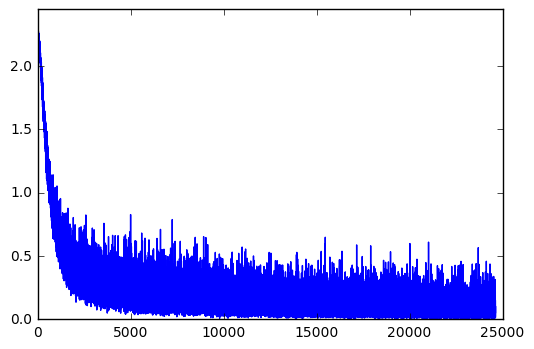

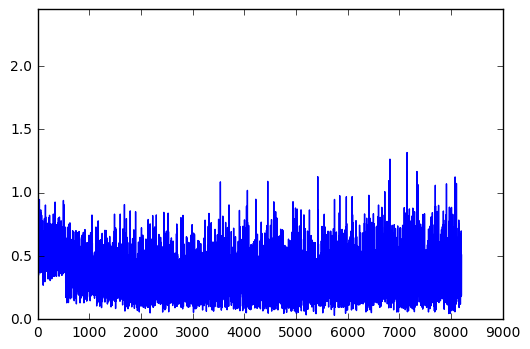

Train report
Batch 0
Batch 100
Batch 200
Batch 300
Batch 400
Batch 500
             precision    recall  f1-score   support

          0       0.98      0.99      0.98      5218
          1       0.99      0.98      0.99      5894
          2       0.97      0.97      0.97      5218
          3       0.98      0.95      0.97      5388
          4       0.98      0.98      0.98      5116
          5       0.98      0.96      0.97      4777
          6       0.98      0.98      0.98      5107
          7       0.98      0.98      0.98      5466
          8       0.93      0.98      0.96      5111
          9       0.97      0.97      0.97      5205

avg / total       0.97      0.97      0.97     52500

Accuracy 0.974704761905
Test report
Batch 0
Batch 100
             precision    recall  f1-score   support

          0       0.97      0.99      0.98      1685
          1       0.98      0.97      0.98      1983
          2       0.96      0.96      0.96      1772
          3       0.96 

In [253]:
mx = np.max([np.max(test_loss_arr), np.max(loss_arr)])
plt.plot(loss_arr)
plt.ylim( (0, mx))
plt.show()


plt.plot(test_loss_arr)
plt.ylim( (0, mx))
plt.show()

make_classification_report(model, images_train, labels_train, images_test, labels_test)

In [270]:
model = DropConnectNet()
loss_fn = torch.nn.NLLLoss(size_average=True)


learning_rate = 1e-4

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


loss_arr, test_loss_arr = learn_on_model(images_train, labels_train, model, loss_fn,images_test,\
                                                    labels_test,\
                                                    learning_rate,\
                                                    max_epoch_num=15, batch_size = 32)

Epoch 1 ...
Train Batch 0
Train Batch 100
Train Batch 200
Train Batch 300
Train Batch 400
Train Batch 500
Train Batch 600
Train Batch 700
Train Batch 800
Train Batch 900
Train Batch 1000
Train Batch 1100
Train Batch 1200
Train Batch 1300
Train Batch 1400
Train Batch 1500
Train Batch 1600
Test Batch 0
Test Batch 100
Test Batch 200
Test Batch 300
Test Batch 400
Test Batch 500
Epoch 2 ...
Train Batch 0
Train Batch 100
Train Batch 200
Train Batch 300
Train Batch 400
Train Batch 500
Train Batch 600
Train Batch 700
Train Batch 800
Train Batch 900
Train Batch 1000
Train Batch 1100
Train Batch 1200
Train Batch 1300
Train Batch 1400
Train Batch 1500
Train Batch 1600
Test Batch 0
Test Batch 100
Test Batch 200
Test Batch 300
Test Batch 400
Test Batch 500
Epoch 3 ...
Train Batch 0
Train Batch 100
Train Batch 200
Train Batch 300
Train Batch 400
Train Batch 500
Train Batch 600
Train Batch 700
Train Batch 800
Train Batch 900
Train Batch 1000
Train Batch 1100
Train Batch 1200
Train Batch 1300
Train Ba

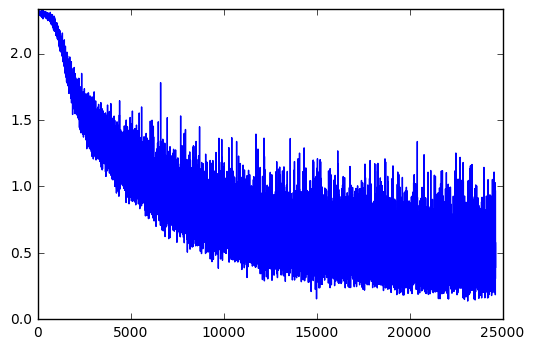

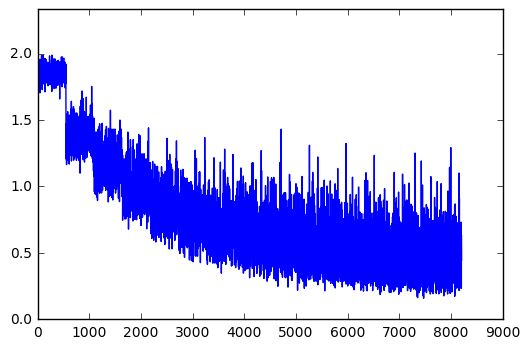

Train report
Batch 0
Batch 100
Batch 200
Batch 300
Batch 400
Batch 500
             precision    recall  f1-score   support

          0       0.93      0.94      0.94      5218
          1       0.92      0.96      0.94      5894
          2       0.91      0.88      0.89      5218
          3       0.88      0.86      0.87      5388
          4       0.85      0.87      0.86      5116
          5       0.82      0.79      0.80      4777
          6       0.92      0.94      0.93      5107
          7       0.88      0.89      0.89      5466
          8       0.81      0.83      0.82      5111
          9       0.83      0.78      0.80      5205

avg / total       0.88      0.88      0.88     52500

Accuracy 0.8764
Test report
Batch 0
Batch 100
             precision    recall  f1-score   support

          0       0.92      0.95      0.94      1685
          1       0.91      0.95      0.93      1983
          2       0.92      0.87      0.89      1772
          3       0.86      0.8

In [271]:
mx = np.max([np.max(test_loss_arr), np.max(loss_arr)])
plt.plot(loss_arr)
plt.ylim( (0, mx))
plt.show()


plt.plot(test_loss_arr)
plt.ylim( (0, mx))
plt.show()

make_classification_report(model, images_train, labels_train, images_test, labels_test)

<i> 2.3 Сделайте выводы по второй части </i>

Видим, что поведение DropConnect хуже, чем Dropout  

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [290]:
# полезные функции: .std(dim), .mean(dim)
# не забывайте, что в pyTorch нет broadcasting (делайте .repeat)

class LayerNormalization(nn.Module):
    def __init__(self, num_features):
        super(LayerNormalization, self).__init__()
        gamma = nn.Parameter(torch.Tensor(1, num_features).normal_(mean=0, std=0.01), requires_grad=True)
        bias = nn.Parameter(torch.Tensor(1, num_features).normal_(mean=0, std=0.01), requires_grad=True)
        self.register_parameter('gamma', gamma)
        self.register_parameter('bias', bias)
        self.is_train = True
    def forward(self, X):
        u = X.mean(1).repeat(1, X.size()[1])
        std = X.std(1).repeat(1, X.size()[1])
        return (self.gamma.repeat(X.size()[0], 1) * (X - u) / std) +  self.bias.repeat(X.size()[0], 1)
    def train(self):
        self.is_train = True
    def test(self):
        self.is_train = False

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с сигмоидами и Batch normalization между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с сигмоидами и Layer normalization между всеми слоями 
</i>

In [288]:
#784 -> 200 -> 200 -> 10 с сигмоидами и Batch normalization между всеми слоями
def BatchNormNet():
    lst = []
    lst.append(nn.Linear(784, 200))
    lst.append(nn.Sigmoid())
    lst.append(nn.BatchNorm1d(200))
    lst.append(nn.Linear(200, 200))
    lst.append(nn.Sigmoid())
    lst.append(nn.BatchNorm1d(200))
    lst.append(nn.Linear(200, 10))
    lst.append(nn.LogSoftmax())
    return nn.Sequential(*lst)

#784 -> 200 -> 200 -> 10 с сигмоидами и Layer normalization между всеми слоями
def LinearNormNet():
    lst = []
    lst.append(nn.Linear(784, 200))
    lst.append(nn.Sigmoid())
    lst.append(LayerNormalization(200))
    lst.append(nn.Linear(200, 200))
    lst.append(nn.Sigmoid())
    lst.append(LayerNormalization(200))
    lst.append(nn.Linear(200, 10))
    lst.append(nn.LogSoftmax())
    return nn.Sequential(*lst)

In [276]:
model = BatchNormNet()
loss_fn = torch.nn.NLLLoss(size_average=True)


learning_rate = 1e-4

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


loss_arr, test_loss_arr = learn_on_model(images_train, labels_train, model, loss_fn,images_test,\
                                                    labels_test,\
                                                    learning_rate,\
                                                    max_epoch_num=15, batch_size = 32)

Epoch 1 ...
Train Batch 0
Train Batch 100
Train Batch 200
Train Batch 300
Train Batch 400
Train Batch 500
Train Batch 600
Train Batch 700
Train Batch 800
Train Batch 900
Train Batch 1000
Train Batch 1100
Train Batch 1200
Train Batch 1300
Train Batch 1400
Train Batch 1500
Train Batch 1600
Test Batch 0
Test Batch 100
Test Batch 200
Test Batch 300
Test Batch 400
Test Batch 500
Epoch 2 ...
Train Batch 0
Train Batch 100
Train Batch 200
Train Batch 300
Train Batch 400
Train Batch 500
Train Batch 600
Train Batch 700
Train Batch 800
Train Batch 900
Train Batch 1000
Train Batch 1100
Train Batch 1200
Train Batch 1300
Train Batch 1400
Train Batch 1500
Train Batch 1600
Test Batch 0
Test Batch 100
Test Batch 200
Test Batch 300
Test Batch 400
Test Batch 500
Epoch 3 ...
Train Batch 0
Train Batch 100
Train Batch 200
Train Batch 300
Train Batch 400
Train Batch 500
Train Batch 600
Train Batch 700
Train Batch 800
Train Batch 900
Train Batch 1000
Train Batch 1100
Train Batch 1200
Train Batch 1300
Train Ba

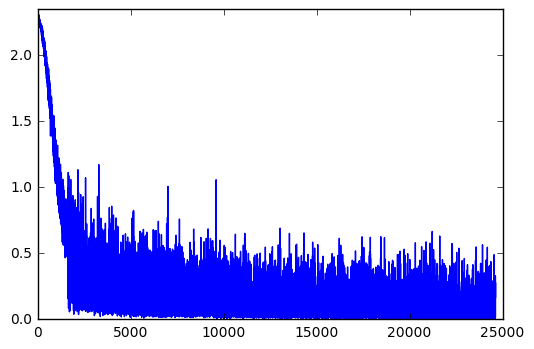

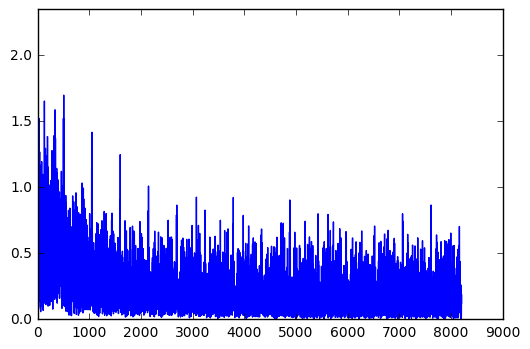

Train report
Batch 0
Batch 100
Batch 200
Batch 300
Batch 400
Batch 500
             precision    recall  f1-score   support

          0       0.99      0.98      0.98      5218
          1       0.99      0.99      0.99      5894
          2       0.97      0.97      0.97      5218
          3       0.95      0.97      0.96      5388
          4       0.98      0.96      0.97      5116
          5       0.98      0.95      0.96      4777
          6       0.98      0.98      0.98      5107
          7       0.99      0.96      0.97      5466
          8       0.95      0.97      0.96      5111
          9       0.94      0.97      0.96      5205

avg / total       0.97      0.97      0.97     52500

Accuracy 0.970857142857
Test report
Batch 0
Batch 100
             precision    recall  f1-score   support

          0       0.97      0.98      0.98      1685
          1       0.98      0.98      0.98      1983
          2       0.96      0.95      0.96      1772
          3       0.94 

In [277]:
mx = np.max([np.max(test_loss_arr), np.max(loss_arr)])
plt.plot(loss_arr)
plt.ylim( (0, mx))
plt.show()


plt.plot(test_loss_arr)
plt.ylim( (0, mx))
plt.show()

make_classification_report(model, images_train, labels_train, images_test, labels_test)

In [291]:
model = LinearNormNet()
loss_fn = torch.nn.NLLLoss(size_average=True)


learning_rate = 1e-4

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


loss_arr, test_loss_arr = learn_on_model(images_train, labels_train, model, loss_fn,images_test,\
                                                    labels_test,\
                                                    learning_rate,\
                                                    max_epoch_num=15, batch_size = 32)

Epoch 1 ...
Train Batch 0
Train Batch 100
Train Batch 200
Train Batch 300
Train Batch 400
Train Batch 500
Train Batch 600
Train Batch 700
Train Batch 800
Train Batch 900
Train Batch 1000
Train Batch 1100
Train Batch 1200
Train Batch 1300
Train Batch 1400
Train Batch 1500
Train Batch 1600
Test Batch 0
Test Batch 100
Test Batch 200
Test Batch 300
Test Batch 400
Test Batch 500
Epoch 2 ...
Train Batch 0
Train Batch 100
Train Batch 200
Train Batch 300
Train Batch 400
Train Batch 500
Train Batch 600
Train Batch 700
Train Batch 800
Train Batch 900
Train Batch 1000
Train Batch 1100
Train Batch 1200
Train Batch 1300
Train Batch 1400
Train Batch 1500
Train Batch 1600
Test Batch 0
Test Batch 100
Test Batch 200
Test Batch 300
Test Batch 400
Test Batch 500
Epoch 3 ...
Train Batch 0
Train Batch 100
Train Batch 200
Train Batch 300
Train Batch 400
Train Batch 500
Train Batch 600
Train Batch 700
Train Batch 800
Train Batch 900
Train Batch 1000
Train Batch 1100
Train Batch 1200
Train Batch 1300
Train Ba

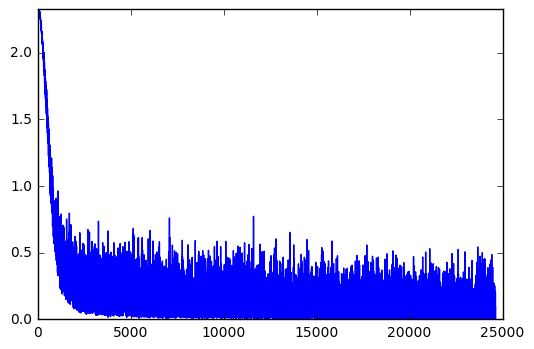

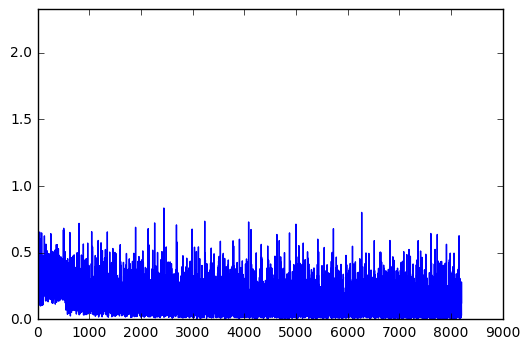

Train report
Batch 0
Batch 100
Batch 200
Batch 300
Batch 400
Batch 500
             precision    recall  f1-score   support

          0       0.98      0.99      0.98      5218
          1       0.99      0.98      0.99      5894
          2       0.96      0.98      0.97      5218
          3       0.96      0.97      0.97      5388
          4       0.97      0.98      0.98      5116
          5       0.97      0.98      0.97      4777
          6       0.99      0.98      0.99      5107
          7       0.99      0.97      0.98      5466
          8       0.95      0.98      0.96      5111
          9       0.98      0.94      0.96      5205

avg / total       0.98      0.98      0.98     52500

Accuracy 0.975523809524
Test report
Batch 0
Batch 100
             precision    recall  f1-score   support

          0       0.96      0.99      0.98      1685
          1       0.99      0.98      0.98      1983
          2       0.95      0.97      0.96      1772
          3       0.95 

In [292]:
mx = np.max([np.max(test_loss_arr), np.max(loss_arr)])
plt.plot(loss_arr)
plt.ylim( (0, mx))
plt.show()


plt.plot(test_loss_arr)
plt.ylim( (0, mx))
plt.show()

make_classification_report(model, images_train, labels_train, images_test, labels_test)

<i> 3.3 Сделайте выводы по третьей части </i>

Видим, что сеть с Layer Normalization обучалась лучше. 

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: